In [2]:
import numpy as np 
np.set_printoptions(threshold=10000, suppress = True) 
import pandas as pd 
import warnings 
import sys
import matplotlib.pyplot as plt 
warnings.filterwarnings('ignore') 

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.discriminant_analysis import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder


from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score

## Partie 1

In [143]:
df = pd.read_csv('mouse.txt', sep=' ', header=None)
df.head(2)

,0,1
0,0.456601,0.432806
1,0.611378,0.528625


<Axes: xlabel='0', ylabel='1'>

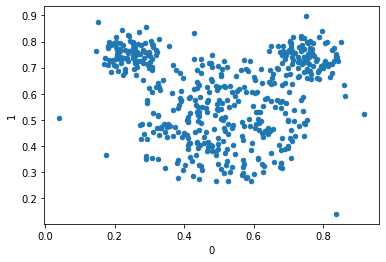

In [3]:
df.plot.scatter(x=0, y=1)
plt.title('Mouse dataset')
plt.show()

### Isolation Forest

In [144]:
# Appliquer la technique Isolation Forest pour détecter les outliers dans ce jeu de données.
IF = IsolationForest(random_state=1).fit(df)
IF_decision = IF.decision_function(df)

#### Via taux de contamination par défaut

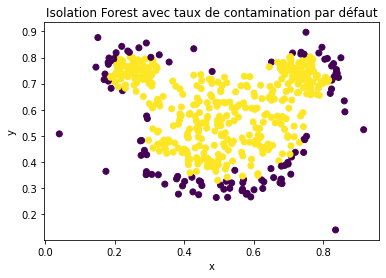

In [145]:
# Utilisation du seuil par défaut
IF_predict = IF.predict(df)
plt.scatter(x=df[0], y=df[1], c=IF_predict);

plt.title("Isolation Forest avec taux de contamination par défaut");
plt.xlabel("x");
plt.ylabel("y");

#### Via détermination d'un seuil de contamination

<p>Le seuil par défaut n'étant pas optimal, nous recherchons nous même un seuil adéquat</p>

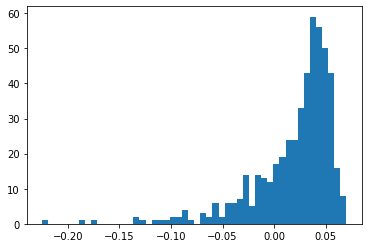

In [5]:
plt.hist(IF_decision, bins=50)
plt.show()

In [6]:
# On observe un gap à partir de -0.1, on va donc utiliser ce seuil
seuil_IF = -0.1
IF_pred = IF_decision.copy()
IF_pred[IF_decision < seuil_IF] = 0
IF_pred[IF_decision >= seuil_IF] = 1

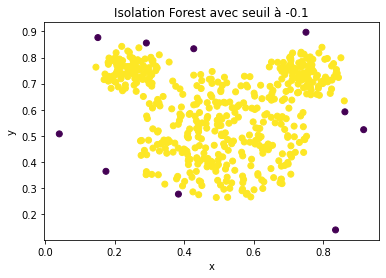

In [7]:
# On constate de bien meilleur résultats avec ce seuil
plt.scatter(df[0], df[1], c=IF_pred)

plt.title(f"Isolation Forest avec seuil à {seuil_IF}")
plt.xlabel("x")
plt.ylabel("y");

### Local Outlier Factor

##### Via taux de contamination par défaut

In [9]:
lof = LocalOutlierFactor(n_neighbors=20)
lof_pred = lof.fit_predict(df)

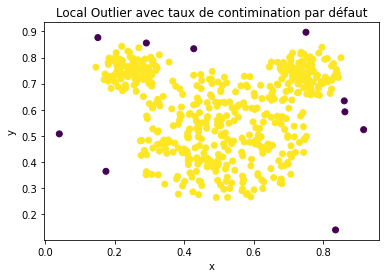

In [10]:
# Par défaut, on note de bons résultats
plt.scatter(x=df[0], y=df[1], c=lof_pred);

plt.title("Local Outlier avec taux de contimination par défaut");
plt.xlabel("x");
plt.ylabel("y");

##### Via détermination d'un seuil de contamination

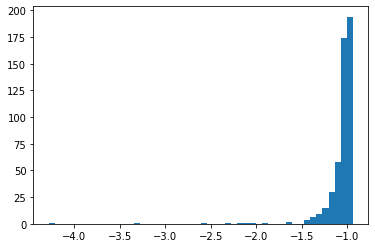

In [11]:
lof = LocalOutlierFactor(n_neighbors=20)
lof.fit(df)
plt.hist(lof.negative_outlier_factor_, bins=50);

In [12]:
# On réapplique la même méthode que précédemment pour trouver un seuil plus optimal
seuil_lof = -1.5
lof_pred = lof.negative_outlier_factor_.copy()
lof_pred[lof.negative_outlier_factor_ < seuil_lof] = 0
lof_pred[lof.negative_outlier_factor_ >= seuil_lof] = 1

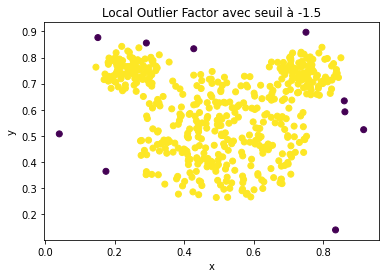

In [13]:
# Nous ne constatons pas de meilleurs résultats avec ce seuil. 
# Le seuil par défaut était déjà efficace
plt.scatter(df[0], df[1], c=lof_pred)
plt.title(f"Local Outlier Factor avec seuil à {seuil_lof}")
plt.xlabel("x")
plt.ylabel("y");

### Conclusion Mouse dataset

In [ ]:
# Les deux approchent (Isolation Forest et Local Outlier Factor), 
# permettent de détecter correctement les outliers dans ce jeu de données.
# Néanmoins, on remarque une meilleur performance lorque le seuil de
# contamination est choisit manuellement. Cela permet d'ajuster le seuil
# en fonction de la distribution des données et donc de mieux s'adapter.
# Dans le cas de l'IF, le taux par défaut va par exemple détecter beaucoup
# trop d'outliers. Le choix du seuil manuel va alors rectifier cela.

## PARTIE 2 : Carte de crédits

La méthodologie emploie les méthodes suivantes :  
**Pré-processing :**
- Normalisation
- PCA
- SMOTE
- Tomek Links
- Encodage des variables catégorielles (*OneHotEncoder*)

**Approche classique :**
- GaussianNB
- Arbre de décision CART
- Random Forest
- XGB boost
- Gradient Boosting
- MLP

**Approche non-spervisée :**
- Isolation Forest
- Local Outlier Factor  

L'ensemble du code a été factorisé dans des fonctions pour faciliter la réutilisation et la lisibilité du code.
Seule la pipeline des fonctions permettant de tester les différents modèles est réécrite à chaque fois pour mettre en évidence les différents pré-traitements et modèles testés.
Cette pipeline peut néanmoins se retrouver dans la fonction ***pipeline()***.


### **I-** Fonctions factorisées

#### 1) Fonctions de pré-processing

In [3]:
####
# TRAITEMENT DES DONNEES
####
def normalize_data(X_train, X_test):
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    return X_train, X_test

def pca_data(X_train, X_test):
    pca = PCA(n_components=0.95)
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)
    return X_train, X_test

def smote_data(X_train, y_train):
    sm = SMOTE(sampling_strategy='minority')
    X_train, y_train = sm.fit_resample(X_train, y_train)
    return X_train, y_train

def tomek_data(X_train, y_train):
    tl = TomekLinks()
    X_train, y_train = tl.fit_resample(X_train, y_train)
    return X_train, y_train

def traitement_data(X_train, y_train, X_test, y_test, listType):
    # Cas vide
    if len(listType) == 0:
        return X_train, y_train, X_test, y_test
    
    # Traitement des données
    if 'norm' in listType:
        X_train, X_test = normalize_data(X_train, X_test)
    if 'pca' in listType:
        X_train, X_test = pca_data(X_train, X_test)
    if 'smote' in listType:
        X_train, y_train = smote_data(X_train, y_train)
    if 'tomek' in listType:
        X_train, y_train = tomek_data(X_train, y_train)    

    return X_train, y_train, X_test, y_test


####
# CHARGEMENT DES DONNEES
####
def load_file_To_DataFrame(file_path):
    try:
        df = pd.read_csv(file_path)
    except:
        print("Erreur lors du chargement de : ", file_path)
        sys.exit(1)
    return df

def split_X_Y(df, target_name):
    # Séparation des features et des labels
    X = df.drop(target_name, axis=1)
    y = df[target_name]
    return X, y

def echantillonage(df, target_name, pourc):
    df_echan = df.groupby(target_name, group_keys=False).apply(lambda x: x.sample(frac=pourc, random_state=1))
    return df_echan

def split_train_test(X, y, test_size, name_stratify):
    # Séparation des données en train et test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=name_stratify, random_state=1)
    return X_train, y_train, X_test, y_test

#### 2) Fonctions de calcul du modèle

In [4]:
def fit(model, X_tr, y_tr):
    model.fit(X_tr, y_tr)
    return model

def fit_unsupervised(model, X_tr):
    model.fit(X_tr)
    return model

def predict(model, X_te):
    Y_pred = model.predict(X_te)
    return Y_pred

def fit_predict(model, X_tr, X_te, y_tr=None):
    if y_tr is None:
        X_concat = np.concatenate([X_tr, X_te])
        model = fit_unsupervised(model, X_concat)
        Y_pred = predict(model, X_te)
        Y_pred[Y_pred == 1] = 0
        Y_pred[Y_pred == -1] = 1
    else:
        model = fit(model, X_tr, y_tr)
        Y_pred = predict(model, X_te)
    return model, Y_pred

def add_score_dict(dict_model, model_name, y_true, Y_pred, probas_pred):
    dict_model[model_name]['confusion_matrix'] = confusion_matrix(y_true, Y_pred)
    dict_model[model_name]['f1_score'] = f1_score(y_true, Y_pred)
    dict_model[model_name]['balanced_accuracy_score'] = balanced_accuracy_score(y_true, Y_pred)
    dict_model[model_name]['average_precision_score'] = average_precision_score(y_true, probas_pred)
    dict_model[model_name]['roc_auc_score'] = roc_auc_score(y_true, probas_pred)
    return dict_model

def run_model(dict_model, model_name, model, X_tr, y_tr, X_te, y_te):
    # On entraine le modèle et on prédit les résultats
    if dict_model[model_name]['type'] == 'supervised':
        model, Y_pred = fit_predict(model, X_tr, X_te, y_tr)
        probas_pred = model.predict_proba(X_te)[:,1]
    else:
        # En cas de non-supervisé, on ne connait pas les labels de test
        # On concatène donc les données d'entrainement et de test
        model, Y_pred = fit_predict(model, X_tr, X_te)
        probas_pred = model.decision_function(X_te)

    # On sauvegarde les résultats    
    dict_model[model_name]['Y_pred'] = Y_pred
    dict_model[model_name]['probas_pred'] = probas_pred

    # On calcule les scores
    add_score_dict(dict_model, model_name, y_te, Y_pred, probas_pred)
    return dict_model

def classement_model(dict_model, metric):
    return sorted(dict_model.items(), key=lambda x: x[1][metric], reverse=True)

def best_model(dict_model, metric):
    return classement_model(dict_model, metric)[0]

def prGreen(skk, prm=''): print("\033[92m {}\033[00m {}\033[00m" .format(skk,prm))


####
# FONCTION A APPELER DIRECTEMENT
####
def grid_search_model(model, param_grid, X_tr, y_tr):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro')
    grid_search.fit(X_tr, y_tr)
    # print("Meilleur paramètre ", grid_search.best_params_)
    return grid_search.best_params_

def compute_model_all(dict_model, X_tr, y_tr, X_te, y_te):
    nb = len(dict_model)
    for model_name, model in dict_model.items():
        print("Calcul de : ", model_name, " (", nb-1, " restant(s))")
        run_model(dict_model, model_name, model['model'], X_tr, y_tr, X_te, y_te)
        nb -= 1
    return dict_model

def compute_model_one(dict_model, model_name, X_tr, y_tr, X_te, y_te):
    print("Calcul de : ", model_name)
    run_model(dict_model, model_name, dict_model[model_name]['model'], X_tr, y_tr, X_te, y_te)
    return dict_model

def print_model_score(dict_model, metric=None, model_name=None):
    print("Résultats :")
    if metric is None:
        for model_name, model in dict_model.items():        
            prGreen(model_name)
            for metric, value in model.items():
                if metric != 'model':
                    print(f"{metric} : {value}")
    else:     
        if model_name is None:   
            sorted_models = classement_model(dict_model, metric)
            for model_name, model in sorted_models:
                prGreen(model_name)
                print(f"{metric} : {model[metric]}")
        else:
            prGreen(model_name)
            print(f"{metric} : {dict_model[model_name][metric]}")

def print_all_score(dict_model, model_name):
    print("Résultats :")
    for metric, value in dict_model[model_name].items():
        if metric != 'model':
            print(f"{metric} : {value}")

def plot_precision_recall_curve(dict_model, model_name, y_true):
    probas_pred = dict_model[model_name]['probas_pred']
    precision, recall, _ = precision_recall_curve(y_true, probas_pred)
    plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("Courbe Precision-Recall du modèle " + model_name)
    plt.legend()
    plt.show()

#### 3) Définition des modèles

In [23]:
# Définition des modèles
def create_model_dict():
    dict_model = {
        'NB': {
            'model': GaussianNB(),
            'type': 'supervised'
        },
        'CART': {
            'model': DecisionTreeClassifier(random_state=1),
            'type': 'supervised'
        },
        'RF': {
            'model': RandomForestClassifier(random_state=1),
            'type': 'supervised'
        },
        'XGB': {
            'model': SGDClassifier(random_state=1, loss='modified_huber'),
            'type': 'supervised'
        },
        'GradientBoosting': {
            'model': GradientBoostingClassifier(random_state=1),
            'type': 'supervised'
        },
        'MLP': {
            'model': MLPClassifier(random_state=1),
            'type': 'supervised'
        }
    }
    return dict_model

def pipeline(X_train, y_train, X_test, y_test, list_preprocess):
    dict_model = create_model_dict()
    X_train, y_train, X_test, y_test = traitement_data(X_train, y_train, X_test, y_test, list_preprocess)

    # Calcul des modèles
    dict_model = compute_model_all(dict_model, X_train, y_train, X_test, y_test)

    # Affichage des résultats
    print_model_score(dict_model, 'f1_score')
    name_best = best_model(dict_model, 'f1_score')[0]
    plot_precision_recall_curve(dict_model, name_best, y_test)   
    

### **II-** Chargement des données

In [122]:
# Chargement des données
df = load_file_To_DataFrame('creditcard.csv')
df.drop('Time', axis=1, inplace=True)

# Echantillonage aléatoire stratifié (Problèmes de performances sinon)
df = echantillonage(df, 'Class', 0.5)

# Séparation des features et des labels
X, y = split_X_Y(df, 'Class')
X_train, y_train, X_test, y_test = split_train_test(X, y, 0.2, y)

### **III-** Modèles

#### 1- Données normalisées

In [123]:
# Création des modèles
dict_model = create_model_dict()
# Normalisation des données
X_train_norm, y_train, X_test_norm, y_test = traitement_data(X_train, y_train, X_test, y_test, ['norm'])

##### Grid Search pour les algorithmes d'OUTLIER DETECTION

In [124]:
# GRID SEARCH pour le modèle ISOLAION FOREST
calcul = False
if calcul:
    param_grid = {
        'n_estimators': [50, 100, 200],
        'contamination': [0.1, 0.172, 0.3]
    }
    best_param = grid_search_model(IsolationForest(random_state=1), param_grid, X_train, y_train)
    print("Meilleur paramètre ", best_param)

    dict_model['IF'] = {
        'model': IsolationForest(contamination=best_param['contamination'], n_estimators=best_param['n_estimators'],random_state=1),
        'type': 'unsupervised'
    }

    ## SORTIE :
    # ==> Meilleur paramètre  {'contamination': 0.1, 'n_estimators': 50}
else:
    dict_model['IF'] = {
        'model': IsolationForest(contamination=0.1, n_estimators=50,random_state=1),
        'type': 'unsupervised'
    }

In [125]:
# GRID SEARCH pour le modèle LOCAL OUTLIER FACTOR
# ATTENTION : Très très long à calculer (+ de 45 min)
calcul = False
if calcul:
    param_grid = {
        'n_neighbors': [2, 5, 10],
        'contamination': [0.1, 0.172, 0.3]
    }

    best_param = grid_search_model(LocalOutlierFactor(), param_grid, X_train, y_train)
    print("Meilleur paramètre ", best_param)

    dict_model['LOF'] = {
        'model': LocalOutlierFactor(n_neighbors=best_param['n_neighbors'], contamination=best_param['contamination'], novelty=True),
        'type': 'unsupervised'
    }

    ## SORTIE :
    # ==> Meilleur paramètre  {'contamination': 0.1, 'n_neighbors': 2}
else:
    dict_model['LOF'] = {
        'model': LocalOutlierFactor(n_neighbors=2, contamination=0.1, novelty=True),
        'type': 'unsupervised'
    }

##### Calcul des modèles

Calcul de :  NB  ( 7  restant(s))
Calcul de :  CART  ( 6  restant(s))
Calcul de :  RF  ( 5  restant(s))
Calcul de :  XGB  ( 4  restant(s))
Calcul de :  GradientBoosting  ( 3  restant(s))
Calcul de :  MLP  ( 2  restant(s))
Calcul de :  IF  ( 1  restant(s))
Calcul de :  LOF  ( 0  restant(s))
Résultats :
 RF 
f1_score : 0.8842105263157894
 MLP 
f1_score : 0.8842105263157894
 CART 
f1_score : 0.7999999999999999
 GradientBoosting 
f1_score : 0.7912087912087913
 XGB 
f1_score : 0.641025641025641
 NB 
f1_score : 0.14106583072100312
 IF 
f1_score : 0.03355015405682985
 LOF 
f1_score : 0.004540295119182747


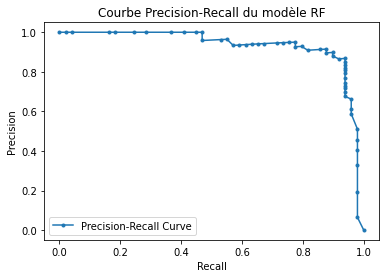

In [126]:
# Calcul des modèles
dict_model = compute_model_all(dict_model, X_train_norm, y_train, X_test_norm, y_test)

# Affichage des résultats
print_model_score(dict_model, 'f1_score')
name_best = best_model(dict_model, 'f1_score')[0]
plot_precision_recall_curve(dict_model, name_best, y_test)

#### 2- Données SMOTE

In [127]:
# Création des modèles
dict_model = create_model_dict()

# Normalisation + SMOTE des données
X_train_smt, y_train_smt, X_test_norm, y_test = traitement_data(X_train, y_train, X_test, y_test, ['norm', 'smote'])

Calcul de :  NB  ( 5  restant(s))
Calcul de :  CART  ( 4  restant(s))
Calcul de :  RF  ( 3  restant(s))
Calcul de :  XGB  ( 2  restant(s))
Calcul de :  GradientBoosting  ( 1  restant(s))
Calcul de :  MLP  ( 0  restant(s))
Résultats :
 RF 
f1_score : 0.9038461538461537
 MLP 
f1_score : 0.8035714285714286
 CART 
f1_score : 0.5029940119760479
 GradientBoosting 
f1_score : 0.2962962962962963
 NB 
f1_score : 0.13872832369942198
 XGB 
f1_score : 0.11267605633802817


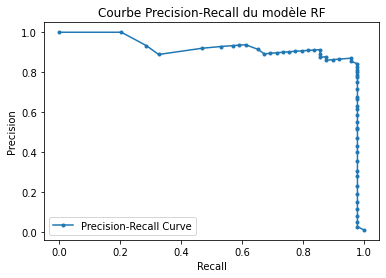

In [128]:
# Calcul des modèles
dict_model = compute_model_all(dict_model, X_train_smt, y_train_smt, X_test_norm, y_test)

# Affichage des résultats
print_model_score(dict_model, 'f1_score')
name_best = best_model(dict_model, 'f1_score')[0]
plot_precision_recall_curve(dict_model, name_best, y_test)

#### 3- Données Tomek Links

In [129]:
# Création des modèles
dict_model = create_model_dict()

# Normalisation + TOMEK des données
X_train_tom, y_train_tom, X_test_norm, y_test = traitement_data(X_train, y_train, X_test, y_test, ['norm', 'tomek'])


Calcul de :  NB  ( 5  restant(s))
Calcul de :  CART  ( 4  restant(s))
Calcul de :  RF  ( 3  restant(s))
Calcul de :  XGB  ( 2  restant(s))
Calcul de :  GradientBoosting  ( 1  restant(s))
Calcul de :  MLP  ( 0  restant(s))
Résultats :
 RF 
f1_score : 0.8775510204081631
 MLP 
f1_score : 0.8653846153846154
 CART 
f1_score : 0.7706422018348624
 GradientBoosting 
f1_score : 0.7659574468085106
 XGB 
f1_score : 0.7073170731707316
 NB 
f1_score : 0.14084507042253522


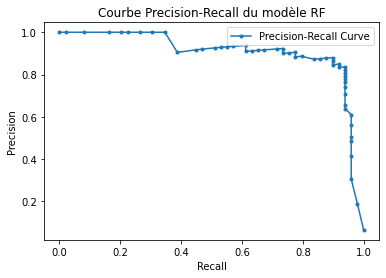

In [130]:
# Calcul des modèles
dict_model = compute_model_all(dict_model, X_train_tom, y_train_tom, X_test_norm, y_test)

# Affichage des résultats
print_model_score(dict_model, 'f1_score')
name_best = best_model(dict_model, 'f1_score')[0]
plot_precision_recall_curve(dict_model, name_best, y_test)

### Conclusion

In [ ]:
# Le meilleur modèle est un random forest avec un f1-score de 0.9038461538461537
# Le pré-traitements des données efficaces sont dans ce cas
# la normalisation et le SMOTE

# A noter que le SMOTE ou le TOMEK n'ont pas toujours d'effet positif
# sur les modèles.

## PARTIE 3 : Intrusion dans les réseaux

### Fonctions factorisées pour partie 3

In [16]:
def encode_categorical(df, categorical_cols):
    encoder = OneHotEncoder(sparse=False)
    encoded_cols = encoder.fit_transform(df[categorical_cols])
    encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names(categorical_cols))
    df = pd.concat([df.drop(categorical_cols, axis=1), encoded_df], axis=1)
    return df

def set_anomalie(label, name_anomalie):
    if label == name_anomalie:
        return 1
    else:
        return 0  

### **I-** Chargement et analyse des variables

In [17]:
df_rsx = load_file_To_DataFrame('./KDDCup99.csv')
print(df_rsx.shape)
df_rsx.head(2)

(494020, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal


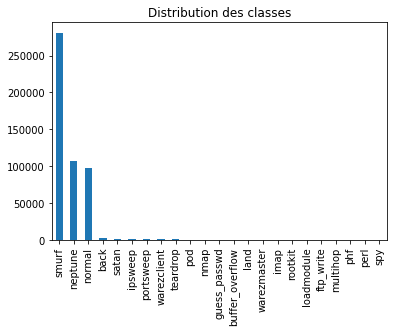

In [177]:
# Analyse de la variable cible
df_rsx['label'].value_counts().plot(kind='bar')
plt.title('Distribution des classes')
plt.show()

In [ ]:
# On remarque que le fichier est à l'origine un problème multi-classe
# On va donc le transformer en problème de détection d'anomalie.
# Pour cela, on va considérer que la classe "normal" est une anomalie
# et que les autres classes sont des données normales.
# Ainsi, on se retrouve dans un jeu désiquilibrés avec 80% de données normales

In [18]:
df_rsx['label'] = df_rsx['label'].apply(lambda x: set_anomalie(x, 'normal'))    
df_rsx['label'].value_counts(normalize=True)

0    0.803091
1    0.196909
Name: label, dtype: float64

### **II-** Pré-processing

In [19]:
# On encode les variables catégorielles
df_rsx = encode_categorical(df_rsx, ['protocol_type', 'service', 'flag'])

# On applique un échantillonage aléatoire stratifié 
# pour réduire le nombre de données (Problèmes de performances sinon)
df_rsx = echantillonage(df_rsx, 'label', 0.5)

# On sépare les données en features et labels
X, y = split_X_Y(df_rsx, 'label')
X_train, y_train, X_test, y_test = split_train_test(X, y, 0.2, y)

### **III-** Modèles

#### 1- Données normalisées

Calcul de :  NB  ( 5  restant(s))
Calcul de :  CART  ( 4  restant(s))
Calcul de :  RF  ( 3  restant(s))
Calcul de :  XGB  ( 2  restant(s))
Calcul de :  GradientBoosting  ( 1  restant(s))
Calcul de :  MLP  ( 0  restant(s))
Résultats :
 RF 
f1_score : 0.9993834138320831
 MLP 
f1_score : 0.9988177846312003
 CART 
f1_score : 0.9987151153826386
 GradientBoosting 
f1_score : 0.9986133223768682
 XGB 
f1_score : 0.9914371195708244
 NB 
f1_score : 0.8849042006098393


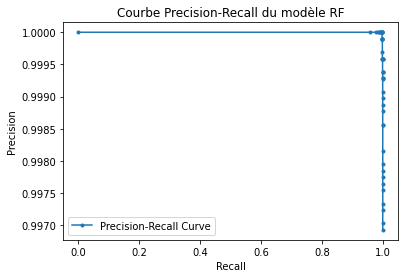

In [24]:
# La fonction pipeline permet de lancer la suite de fonction habituelle
# pour le traitement des données et le calcul des modèles (comme ci-dessus)

# Dans le cadre de ce TP, j'ai laissé les fonctions en dur pour montrer
# les différentes étapes.
# Dans un cadre de mise en production, j'utiliserai directement la fonction
# pipeline avec les paramètres adéquats comme ci-dessous.
pipeline(X_train, y_train, X_test, y_test, ['norm'])

#### 2- Données SMOTE

Calcul de :  NB  ( 5  restant(s))
Calcul de :  CART  ( 4  restant(s))
Calcul de :  RF  ( 3  restant(s))
Calcul de :  XGB  ( 2  restant(s))
Calcul de :  GradientBoosting  ( 1  restant(s))
Calcul de :  MLP  ( 0  restant(s))
Résultats :
 RF 
f1_score : 0.9993834771886559
 MLP 
f1_score : 0.9988698243090518
 CART 
f1_score : 0.9988691271717898
 GradientBoosting 
f1_score : 0.9968738789524931
 XGB 
f1_score : 0.9940506718637808
 NB 
f1_score : 0.8853862973760933


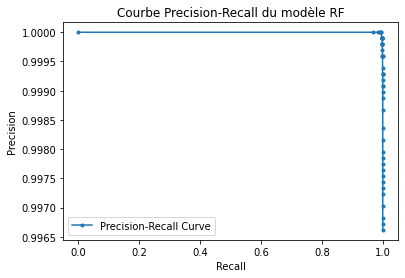

In [13]:
# Création des modèles
dict_model = create_model_dict()
# Normalisation + SMOTE
X_train_smt, y_train_smt, X_test_norm, y_test = traitement_data(X_train, y_train, X_test, y_test, ['norm', 'smote'])

# Calcul des modèles
dict_model = compute_model_all(dict_model, X_train_smt, y_train_smt, X_test_norm, y_test)

# Affichage des résultats
print_model_score(dict_model, 'f1_score')
name_best = best_model(dict_model, 'f1_score')[0]
plot_precision_recall_curve(dict_model, name_best, y_test)

### 3- Données Tomek Links

Calcul de :  NB  ( 5  restant(s))
Calcul de :  CART  ( 4  restant(s))
Calcul de :  RF  ( 3  restant(s))
Calcul de :  XGB  ( 2  restant(s))
Calcul de :  GradientBoosting  ( 1  restant(s))
Calcul de :  MLP  ( 0  restant(s))
Résultats :
 RF 
f1_score : 0.9993321346005651
 MLP 
f1_score : 0.9988690108986223
 CART 
f1_score : 0.9986118965605881
 GradientBoosting 
f1_score : 0.9977426636568848
 XGB 
f1_score : 0.9917193848685901
 NB 
f1_score : 0.8848236632536974


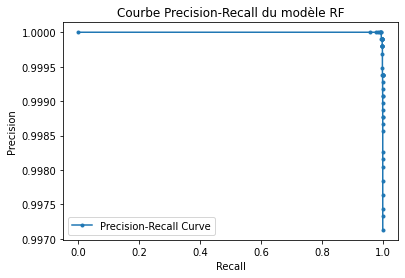

In [14]:
# Création des modèles
dict_model = create_model_dict()
# Normalisation + TOMEK
X_train_tom, y_train_tom, X_test_norm, y_test = traitement_data(X_train, y_train, X_test, y_test, ['norm', 'tomek'])

# Calcul des modèles
dict_model = compute_model_all(dict_model, X_train_tom, y_train_tom, X_test_norm, y_test)

# Affichage des résultats   
print_model_score(dict_model, 'f1_score')
name_best = best_model(dict_model, 'f1_score')[0]
plot_precision_recall_curve(dict_model, name_best, y_test)

### Conclusion

<p>Le meilleur modèle est un <b>random forest avec un f1-score de 0.9993834771886559</b><br/>
L'application de SMOTE ou de TOMEK n'a pas d'effet sur les modèles.
Le modèle est en effet déjà très performant sans ces pré-traitements.</p>

## PARTIE 4 : Détection de nouveauté

<p>Nous pouvons utiliser une méthodologie similaire à celle déjà effectuée pour comparer les des approches d'Isolation Forest et Local Outlier Factor : </p>
<li>Pré-processing : Normalisation des données</li>
<li>Entrainement des modèles : Fit_predict des modèles <br/>
<b>Attention : </b> Pour utiliser le Local Outlier Factor dans le cadre de *détection de nouveauté*, il est essentiel d'appliquer le paramètre *novelty=True*</li>
<li> Evaluation des modèles : Le F1-score ou l'AUC-PR sont des métriques efficaces dans le cadre de jeux de données déséquilibrés</li>